In [55]:
# 모델 분석에 필요한 라이브러리 import

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
import platform

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest

# 모듈로 구현한 데이터 분석용 클래스 import 
from modules.DataAnalysis import DataCheck
from modules.DataAnalysis import DataPreprocessing
from modules.DataAnalysis import DataVisualize
import modules.DataModify as DataModify

In [56]:
### 데이터 로드

input_file_path = './data/Tree_data.csv'

df = pd.read_csv(input_file_path)

### 객체 인스턴스 생성
dc = DataCheck(df)
dp = DataPreprocessing(df)
dv = DataVisualize(df)

In [57]:
drop_cols = ['No', 'Plot', 'Adult', 'Subplot', 'Core', 'Census', 'Time']
dp.set_drop_cols(drop_cols)

In [58]:
encode = dp.run(encoding='label', return_anomaly=False)

In [59]:
alive_data = encode[encode['Alive'] != 1]
censored_data = encode[encode['Alive'] == 1]

train_set, test_set = DataModify.train_test_split_ignore_censored(alive_data, censored_data)

# (train_set[0] : X_train, train_set[1] : y_train, test_set[0] : X_test, test_set[1] : y_test)

print(train_set[1].value_counts())

Alive
0    1812
1     554
Name: count, dtype: int64


In [60]:
# XGBoost
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier

X_train, y_train = train_set
X_test, y_test = test_set

# y_train 처리
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.iloc[:, 0]  
y_train = y_train.values.ravel()
y_train = y_train.astype(int)

# y_test 처리
if isinstance(y_test, pd.DataFrame):
    y_test = y_test.iloc[:, 0] 
y_test = y_test.values.ravel()
y_test = y_test.astype(int)

# XGB 모델 생성
xgb_clf = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42, 
    enable_categorical=True 
)

xgb_clf.fit(X_train, y_train)

y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)

# 정확도
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

# 혼동 행렬
print(confusion_matrix(y_test, y_pred_test)) 
print(classification_report(y_test, y_pred_test)) 


0.8431952662721893
0.8317307692307693
[[284  28]
 [ 42  62]]
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       312
           1       0.69      0.60      0.64       104

    accuracy                           0.83       416
   macro avg       0.78      0.75      0.76       416
weighted avg       0.83      0.83      0.83       416



[0]	validation_0-logloss:0.52215	validation_1-logloss:0.52899
[1]	validation_0-logloss:0.50430	validation_1-logloss:0.50111
[2]	validation_0-logloss:0.48987	validation_1-logloss:0.47778
[3]	validation_0-logloss:0.47753	validation_1-logloss:0.45792
[4]	validation_0-logloss:0.46662	validation_1-logloss:0.44054
[5]	validation_0-logloss:0.45807	validation_1-logloss:0.42580
[6]	validation_0-logloss:0.44997	validation_1-logloss:0.41273
[7]	validation_0-logloss:0.44349	validation_1-logloss:0.40106
[8]	validation_0-logloss:0.43782	validation_1-logloss:0.39096
[9]	validation_0-logloss:0.43280	validation_1-logloss:0.38221
[10]	validation_0-logloss:0.42826	validation_1-logloss:0.37434
[11]	validation_0-logloss:0.42441	validation_1-logloss:0.36723
[12]	validation_0-logloss:0.42120	validation_1-logloss:0.36089
[13]	validation_0-logloss:0.41810	validation_1-logloss:0.35558
[14]	validation_0-logloss:0.41522	validation_1-logloss:0.35127
[15]	validation_0-logloss:0.41252	validation_1-logloss:0.34722
[1

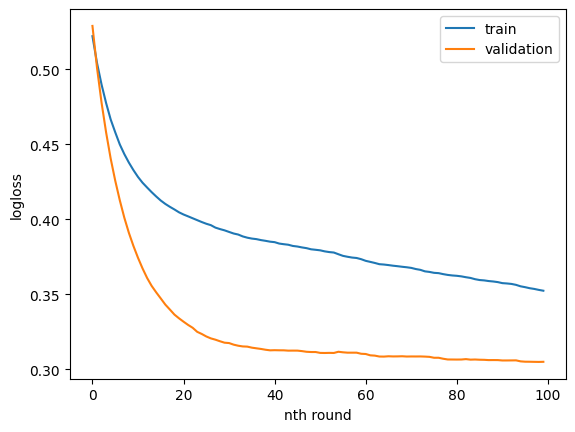

In [61]:
# 학습 곡선
eval_set = [(X_train, y_train), ([X_test, y_test])]

xgb_clf.fit(X_train, y_train, eval_set=eval_set, verbose=True)

result = xgb_clf.evals_result() 

train_loss = result['validation_0']['logloss'] 
val_loss = result['validation_1']['logloss'] 

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='validation')
plt.xlabel('nth round')
plt.ylabel('logloss')
plt.legend()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

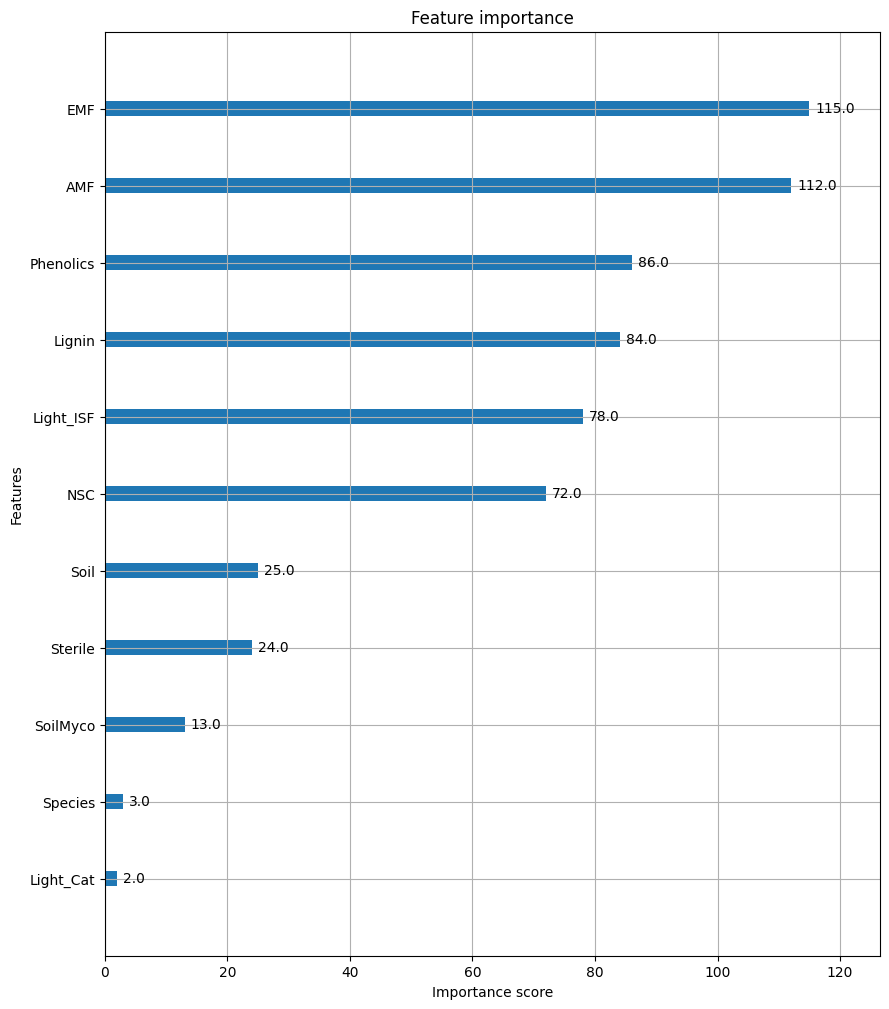

In [62]:
# 중요도
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(10,12)) 
plot_importance(xgb_clf, ax=ax) 
plt.show


In [66]:
print(type(X_train))
print(type(y_train))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [67]:
# KFold
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

cv_accuracy = []

X = X_train.copy()
y = y_train.copy()

for train_index, val_index in kfold.split(X):
     
    X_tr = X.iloc[train_index]       
    X_val = X.iloc[val_index]
    
    y_tr = y[train_index]            
    y_val = y[val_index]

    print(np.unique(y_tr, return_counts=True))
    print(np.unique(y_val, return_counts=True))
    print('==================================')

    xgb_clf.fit(X_tr, y_tr)
    y_pred = xgb_clf.predict(X_val)
    acc_score = accuracy_score(y_val, y_pred)
    cv_accuracy.append(acc_score)

# 결과 출력
print("훈련별 정확도:", cv_accuracy)
print("분류모델 평균 정확도:", np.mean(cv_accuracy))

(array([0, 1]), array([1453,  439]))
(array([0, 1]), array([359, 115]))
(array([0, 1]), array([1448,  445]))
(array([0, 1]), array([364, 109]))
(array([0, 1]), array([1443,  450]))
(array([0, 1]), array([369, 104]))
(array([0, 1]), array([1441,  452]))
(array([0, 1]), array([371, 102]))
(array([0, 1]), array([1463,  430]))
(array([0, 1]), array([349, 124]))
훈련별 정확도: [0.759493670886076, 0.7632135306553911, 0.7822410147991543, 0.7843551797040169, 0.7780126849894292]
분류모델 평균 정확도: 0.7734632162068135


In [71]:
# GridSearchCV
from sklearn.model_selection import GridSearchCV

params = { 
    'n_estimators' : range(100, 1000, 100),
    'max_depth' : range(1, 10, 1),
    'learning_rate' : np.arange(0.01, 0.1, 0.01), 
    'enable_categorical' : [True, False] 
}

grid = GridSearchCV(xgb_clf, params, scoring="accuracy", cv=5)

grid.fit(X_train, y_train)

print('최적의 파라미터:', grid.best_params_) 
print('최적화된 모델 객체:', grid.best_estimator_) 
print('최적화된 점수:', grid.best_score_) 

최적의 파라미터: {'enable_categorical': True, 'learning_rate': np.float64(0.04), 'max_depth': 2, 'n_estimators': 900}
최적화된 모델 객체: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=np.float64(0.04), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=900, n_jobs=None,
              num_parallel_tree=None, ...)
최적화된 점수: 0.779360576622867


In [72]:
# 최적의 파라미터: {'enable_categorical': True, 'learning_rate': np.float64(0.04), 'max_depth': 2, 'n_estimators': 900}

xgb_grid = XGBClassifier(
    n_estimators=900,
    max_depth=2,
    learning_rate=0.04,
    random_state=42, 
    enable_categorical=True 
)

xgb_grid.fit(X_train, y_train)

y_pred_train = xgb_grid.predict(X_train)
y_pred_test = xgb_grid.predict(X_test)

# 정확도
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))


0.8558748943364328
0.8389423076923077
